# OPTRAM

In [1]:
import pandas as pd
import utm 
import folium
import geopandas as gpd
from shapely import geometry
from osgeo import gdal
from skimage import exposure
import rasterio
import numpy as np
import numpy.ma as ma
from rasterio import plot
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
from scipy import stats

## REGION OF STUDY


In [2]:
swrc = gpd.read_file('./WG-boundary/boundary/boundary.shp')
swrc

,MAJOR_SUBW,Shape_Leng,Shape_Area,geometry
0,1.0,78272.01636,1.477542e+08,"POLYGON ((605817.380 3515703.128, 605817.505 3..."


In [3]:
def utm_to_latlon(coords, zone_number, zone_letter):
    easting = coords[0]
    northing = coords[1]
    return utm.to_latlon(easting, northing, zone_number, zone_letter)

In [4]:
# Arizona
utm_N = 12 
utm_Z = 'N'

x,y = swrc.geometry[0].exterior.coords.xy
points = []
for i in range(len(swrc.geometry[0].exterior.coords.xy[1])) : 
    points.append(utm_to_latlon(coords = [x[i], y[i]], zone_number = utm_N, zone_letter = utm_Z))
    
# points

In [5]:
points_rev = [(y,x) for x,y in points]
swrc['geometry'] = geometry.Polygon(points_rev)

In [6]:
m = folium.Map(location=[31.77196086872937, -109.8824988259172], zoom_start=10)
for _, r in swrc.iterrows():
    sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j,
                           style_function=lambda x: {'fillColor': 'orange'})
    geo_j.add_to(m)
m

 Shapefile to geojson conversion

In [7]:
swrc.to_crs(epsg=4326)
swrc.to_file('./sen2r/Walnut-Gulch.geojson', driver='GeoJSON')

## LOAD DATA

### Sensor 

In [8]:
names = ["site", "year", "day", "hr", "mn", "SM5", "SM15", "SM30", "SM50", "SM75", "SM100", "SM200"]
l1tdr17 = pd.read_csv('https://www.tucson.ars.ag.gov/metDAP/SoilProfileSiteData/l1tdr17.out',
                  sep='\s+', 
                  names = names)

In [9]:
l1tdr17["datetime"] = (
                        pd.to_datetime(l1tdr17['year'] * 1000 + l1tdr17['day'], format='%Y%j') 
                        +
                        pd.to_timedelta(l1tdr17["hr"], unit="h") 
                        +
                        pd.to_timedelta(l1tdr17["mn"], unit="min") 
                      )

In [10]:
l1tdr17.set_index('datetime', inplace = True)

In [11]:
l1tdr17

,site,year,day,hr,mn,SM5,SM15,SM30,SM50,SM75,SM100,SM200
datetime,,,,,,,,,,,,
2017-01-01 00:30:00,3008,2017,1,0,30,11,8,6,6,15,12,14
2017-01-01 01:00:00,3008,2017,1,1,0,11,9,6,6,14,12,14
2017-01-01 01:30:00,3008,2017,1,1,30,11,8,6,6999,15,13,14
2017-01-01 02:00:00,3008,2017,1,2,0,11,8,6,6,15,12,14
2017-01-01 02:30:00,3008,2017,1,2,30,12,7,6,6,14,12,13
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-31 22:00:00,3008,2017,365,22,0,5,6,6,5,11,12,14
2017-12-31 22:30:00,3008,2017,365,22,30,5,6,7,6,11,12,14
2017-12-31 23:00:00,3008,2017,365,23,0,5,6,5,6,12,12,14


<AxesSubplot:xlabel='datetime'>

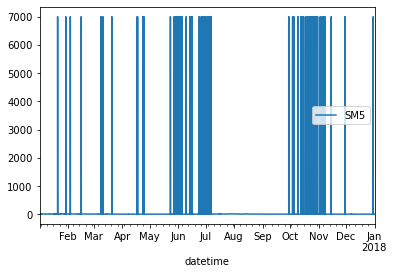

In [12]:
l1tdr17.plot(y='SM5', use_index=True)

In [13]:
l1tdr17_fix = l1tdr17.replace(6999, None)

<AxesSubplot:xlabel='datetime'>

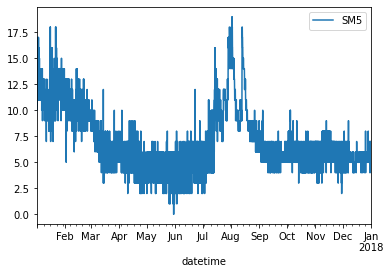

In [14]:
l1tdr17_fix.plot(y='SM5', use_index=True)

### Satellite

In [15]:
import rasterio as rs

In [16]:
boa_fp = r"./sen2r/out/BOA/S2A2A_20181213_141_Walnut-Gulch_BOA_10.tif"
boa = rs.open(boa_fp) 

In [17]:
boa.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': 65535.0,
 'width': 2607,
 'height': 1214,
 'count': 11,
 'crs': CRS.from_epsg(32612),
 'transform': Affine(10.0, 0.0, 580180.0,
        0.0, -10.0, 3515720.0)}

In [18]:
boa.profile

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 2607, 'height': 1214, 'count': 11, 'crs': CRS.from_epsg(32612), 'transform': Affine(10.0, 0.0, 580180.0,
       0.0, -10.0, 3515720.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}

In [19]:
boa.bounds

BoundingBox(left=580180.0, bottom=3503580.0, right=606250.0, top=3515720.0)

In [20]:
boa.indexes

(1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)

----------

In [21]:
red = boa.read(3, masked = True)
green = boa.read(4, masked = True)
blue = boa.read(5, masked = True)

In [22]:
type(red)

numpy.ma.core.MaskedArray

<AxesSubplot:title={'center':'B'}>

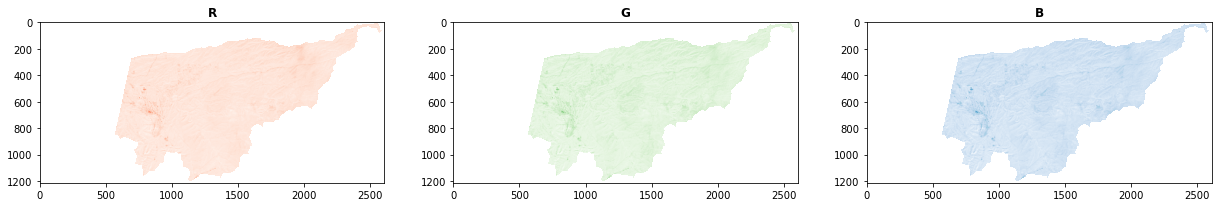

In [23]:
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
show(red, ax=axr, cmap='Reds', title='R')
show(green, ax=axg, cmap='Greens', title='G')
show(blue, ax=axb, cmap='Blues', title='B')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


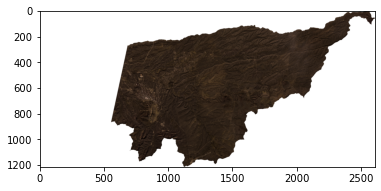

In [24]:
# Normalize bands into 0.0 - 1.0 scale
def normalize(array):
    array_min, array_max = array.min(), array.max()
    return (array - array_min) / (array_max - array_min)

red_norm = normalize(red)
green_norm = normalize(green)
blue_norm = normalize(blue)

bgr = np.dstack((blue_norm, green_norm, red_norm))
plt.imshow(bgr)

----

In [25]:
ndvi_fp = "./sen2r/indices/NDMI/S2A2A_20181213_141_Walnut-Gulch_NDMI_10.tif"
ndvi_rs = rs.open(boa_fp, driver='GTiff', dtype = 'float32') 
ndvi = ndvi_rs.read(1, masked = True)

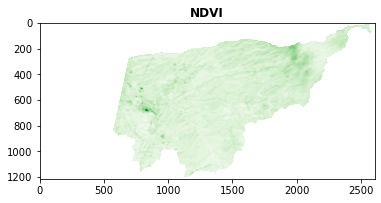

<AxesSubplot:title={'center':'NDVI'}>

In [26]:
show(ndvi, title='NDVI', cmap = "Greens")

In [27]:
ndvi = ndvi / 10000

In [ ]:
plt.hist(ndvi,bins = 10)
plt.show()